<a href="https://colab.research.google.com/github/vasatodorovic/Face-detection-and-recognition/blob/main/0_FaceDection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
print(torch.cuda.is_available())

False


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!pip install torch torchvision opencv-python

In [3]:
import os
from PIL import Image
import torch
import numpy as np
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from torch.utils.data import random_split

In [25]:
class FaceDataset(Dataset):
    def __init__(self, img_dir, label_dir, img_size=448, grid_size=14, num_bboxes=1,max_images=None,transform=None):
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.img_size = img_size
        self.grid_size = grid_size
        self.num_bboxes = num_bboxes
        self.transform = transform
        #self.img_files = [f for f in os.listdir(img_dir) if f.endswith('.jpg')]
        self.img_files = []
        count = 0
        for img_file in os.listdir(img_dir):
            if img_file.endswith('.jpg'):
                self.img_files.append(img_file)
                count += 1
                if max_images is not None and count >= max_images:
                    break

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_files[idx])
        img = Image.open(img_path).convert("RGB")
        img = img.resize((self.img_size, self.img_size))

        if self.transform:
            img = self.transform(img)

        label_path = os.path.join(self.label_dir, self.img_files[idx].replace('.jpg', '.txt'))
        boxes = []

        if os.path.exists(label_path):
            with open(label_path, 'r') as file:
                for line in file:
                    _, x_center, y_center, width, height = map(float, line.strip().split())
                    boxes.append([x_center, y_center, width, height, 1.0])
        #print(f"Image: {img_path}")
        #print(f"Boxes: {boxes}")
        target_grid = self.map_targets_to_grid(boxes, self.grid_size, self.num_bboxes)

        return img, target_grid

    def map_targets_to_grid(self, targets, grid_size, num_bboxes):
        target_grid = torch.zeros((grid_size, grid_size, num_bboxes * 5))

        for target in targets:
            x_center, y_center, width, height, conf = target

            grid_x = int(x_center * grid_size)
            grid_y = int(y_center * grid_size)

            bbox_index = 0
            #print(f"Target: {target}")
            #print(f"Grid position: ({grid_y}, {grid_x})")
            target_grid[grid_y, grid_x, bbox_index * 5:bbox_index * 5 + 4] = torch.tensor([x_center, y_center, width, height])
            target_grid[grid_y, grid_x, bbox_index * 5 + 4] = conf
        #print(f"Target grid:\n{target_grid}")
        return target_grid

In [31]:
img_dir_train='/content/drive/My Drive/YoloData/images/train'
label_dir_train='/content/drive/My Drive/YoloData/labels/train'
img_dir_test='/content/drive/My Drive/YoloData/images/val'
label_dir_test='/content/drive/My Drive/YoloData/labels/val'

data_transforms = transforms.Compose([
    transforms.ToTensor()
])

train_val_dataset = FaceDataset(
    img_dir=img_dir_train,
    label_dir=label_dir_train,
    transform=data_transforms,
    max_images=3500
)
train_size = int(0.8 * len(train_val_dataset))
val_size = len(train_val_dataset) - train_size
train_dataset, val_dataset = random_split(train_val_dataset, [train_size, val_size])

test_dataset = FaceDataset(
    img_dir=img_dir_test,
    label_dir=label_dir_test,
    transform=data_transforms,
    max_images=1000
)

In [32]:
#first_image, first_boxes = train_dataset[0]

In [33]:
#import matplotlib.pyplot as plt
#plt.imshow(first_image.permute(1, 2, 0))  #(C, H, W) to (H, W, C)
#plt.axis('off')
#plt.show()


In [34]:
def collate_fn(batch):
    images, targets = zip(*batch)

    images = torch.stack(images, dim=0)

    return images, targets

In [35]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2,collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=2,collate_fn=collate_fn)

In [37]:
# import torch

# for i, (images, targets) in enumerate(train_loader):
#     print(f"Batch {i+1}:")
#     print(f"Images shape: {images.shape}")

#     for j, target in enumerate(targets):
#         print(f"Image {j+1} in Batch {i+1}:")
#         print(f"Target grid:\n{target}")

#     if i >= 2:
#         break

In [ ]:
import torch
import torch.nn as nn
import numpy as np

In [ ]:
class YOLO(nn.Module):
  def __init__(self,grid_size=14,num_bboxes=1):
    super(YOLO,self).__init__()
    self.grid_size=grid_size
    self.num_bboxes=num_bboxes
    self.num_classes=1

    self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 192, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(192),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(192, 128, kernel_size=1, stride=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1),

            nn.Conv2d(256, 256, kernel_size=1, stride=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(kernel_size=2, stride=2) #14x14x512
        )

    self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * self.grid_size * self.grid_size, 4096),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.5),
            nn.Linear(4096, self.grid_size * self.grid_size * (self.num_bboxes * 5))
        )

  def forward(self, x):

        x = self.conv_layers(x)
        x = self.fc_layers(x)

        x = x.view(-1, self.grid_size, self.grid_size, self.num_bboxes * 5)

        bboxes = torch.sigmoid(x[..., :self.num_bboxes * 5])

        return bboxes
  def predict(self, x, iou_threshold=0.5, confidence_threshold=0.5):
        bboxes = self.forward(x)

        filtered_boxes = []
        filtered_scores = []


        for i in range(self.grid_size):
            for j in range(self.grid_size):
                for b in range(self.num_bboxes):
                    offset = b * 5
                    confidence = bboxes[:, i, j, offset + 4]
                    if confidence > confidence_threshold:
                        box = bboxes[:, i, j, offset:offset + 4]
                        score = confidence
                        filtered_boxes.append(box)
                        filtered_scores.append(score)


        if len(filtered_boxes) == 0:
            return [], []

        filtered_boxes = torch.stack(filtered_boxes)
        filtered_scores = torch.stack(filtered_scores)


        keep_indices = nms(filtered_boxes, filtered_scores, iou_threshold)
        final_boxes = filtered_boxes[keep_indices]
        final_scores = filtered_scores[keep_indices]


        return final_boxes, final_scores


In [ ]:
def xywh_to_xyxy(box):
    x_center, y_center, width, height = box[:4]
    x_min = x_center - (width / 2)
    y_min = y_center - (height / 2)
    x_max = x_center + (width / 2)
    y_max = y_center + (height / 2)
    return torch.tensor([x_min, y_min, x_max, y_max])

In [ ]:
def iou(box1, box2):
    box1 = xywh_to_xyxy(box1)
    box2 = torch.stack([xywh_to_xyxy(b) for b in box2])

    inter_x_min = torch.max(box1[0], box2[:, 0])
    inter_y_min = torch.max(box1[1], box2[:, 1])
    inter_x_max = torch.min(box1[2], box2[:, 2])
    inter_y_max = torch.min(box1[3], box2[:, 3])

    inter_area = torch.clamp(inter_x_max - inter_x_min, min=0) * torch.clamp(inter_y_max - inter_y_min, min=0)
    area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area2 = (box2[:, 2] - box2[:, 0]) * (box2[:, 3] - box2[:, 1])

    iou = inter_area / (area1 + area2 - inter_area)
    return iou

In [ ]:
def nms(bboxes, scores, iou_threshold=0.5):
    keep = []
    indices = scores.sort(descending=True)[1]

    while indices.numel() > 0:
        current = indices[0]
        keep.append(current.item())
        if indices.numel() == 1:
            break

        ious = iou(bboxes[current], bboxes[indices[1:]])
        indices = indices[1:][ious < iou_threshold]

    return keep

In [ ]:
model = YOLO()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

YOLO(
  (conv_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.1)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(192, 128, kernel_size=(1, 1), stride=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.1)
    (11): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): LeakyReLU(negative_s

In [ ]:
import torch.optim as optim

In [ ]:
import torch

def yolo_loss(pred_bboxes, target, lambda_coord=5, lambda_noobj=0.5):

    obj_mask_1 = target[..., 4] > 0
    obj_mask_2 = target[..., 9] > 0

    noobj_mask_1 = target[..., 4] == 0
    noobj_mask_2 = target[..., 9] == 0

    coord_loss_1 = lambda_coord * torch.sum((pred_bboxes[obj_mask_1][..., :4] - target[obj_mask_1][..., :4]) ** 2)
    coord_loss_2 = lambda_coord * torch.sum((pred_bboxes[obj_mask_2][..., 5:9] - target[obj_mask_2][..., 5:9]) ** 2)

    obj_loss_1 = torch.sum((pred_bboxes[obj_mask_1][..., 4] - target[obj_mask_1][..., 4]) ** 2)
    obj_loss_2 = torch.sum((pred_bboxes[obj_mask_2][..., 9] - target[obj_mask_2][..., 9]) ** 2)

    noobj_loss_1 = lambda_noobj * torch.sum(pred_bboxes[noobj_mask_1][..., 4] ** 2)
    noobj_loss_2 = lambda_noobj * torch.sum(pred_bboxes[noobj_mask_2][..., 9] ** 2)

    loss = coord_loss_1 + coord_loss_2 + obj_loss_1 + obj_loss_2 + noobj_loss_1 + noobj_loss_2
    return loss


In [ ]:
from tqdm import tqdm

def train_model(model, train_loader, val_loader, num_epochs=10, learning_rate=0.001,checkpoint_dir='checkpoints'):
    training_losses = []
    validation_losses = []

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    model.train()

    for epoch in range(num_epochs):
        running_loss = 0.0
        progress_bar = tqdm(train_loader, desc=f"Epoch [{epoch + 1}/{num_epochs}]")

        for images, targets in progress_bar:
            images = images.to(device)

            targets = [target.to(device) for target in targets]

            optimizer.zero_grad()

            bboxes = model(images) #(32,7,7,5+5)

            losses = [yolo_loss(bbox, target) for bbox, target in zip(bboxes, targets)]
            loss = torch.mean(torch.stack(losses))

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            progress_bar.set_postfix({'Loss': loss.item()})

        avg_loss = running_loss / len(train_loader)
        training_losses.append(avg_loss)
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss}")

        model.eval()
        val_running_loss = 0.0
        with torch.no_grad():
            for val_images, val_targets in val_loader:
                val_images = val_images.to(device)
                val_targets = [val_target.to(device) for val_target in val_targets]

                val_bboxes = model(val_images)
                val_losses = [yolo_loss(val_bbox, val_target) for val_bbox, val_target in zip(val_bboxes, val_targets)]
                val_loss = torch.mean(torch.stack(val_losses))

                val_running_loss += val_loss.item()

        avg_val_loss = val_running_loss / len(val_loader)
        validation_losses.append(avg_val_loss)
        print(f"Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {avg_val_loss}")

        model.train()
        save_checkpoint(model, optimizer, epoch + 1, avg_loss, checkpoint_dir)

    print("Training complete!")
    return training_losses,validation_losses


In [ ]:
def save_checkpoint(model, optimizer, epoch, loss, checkpoint_dir="checkpoints"):
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)

    checkpoint_path = os.path.join(checkpoint_dir, f"model_epoch_{epoch}_loss_{loss:.4f}.pth")
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }, checkpoint_path)
    print(f"Checkpoint saved at {checkpoint_path}")

In [ ]:
def load_checkpoint(checkpoint_path, model, optimizer):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    print(f"Loaded checkpoint '{checkpoint_path}' (epoch {epoch}, loss {loss})")
    return epoch, loss

In [ ]:
train_model(model,train_loader,num_epochs=1)

Epoch [1/1]:   0%|          | 0/125 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7afd54fc5c60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionErrorException ignored in: : <function _MultiProcessingDataLoaderIter.__del__ at 0x7afd54fc5c60>can only test a child process
Traceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shu

Epoch [1/1], Loss: 17.112139720916748
Checkpoint saved at checkpoints/model_epoch_1_loss_17.1121.pth
Training complete!


In [ ]:
model.eval()

with torch.no_grad():
    images, _ = next(iter(test_loader))
    image = images[0].unsqueeze(0)
    image = image.to(device)

    predictions = model(image)
    print(predictions)

In [ ]:
final_boxes

[]

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

def draw_bounding_box(image_path, boxes, save_path=None):

    image = Image.open(image_path).convert("RGB")
    image = image.resize((448, 448))
    draw = ImageDraw.Draw(image)

    for box in boxes:
        draw.rectangle(xywh_to_xyxy(box), outline="red", width=3)

    if save_path:
        image.save(save_path)
    else:
        plt.imshow(image)
        plt.axis('off')
        plt.show()

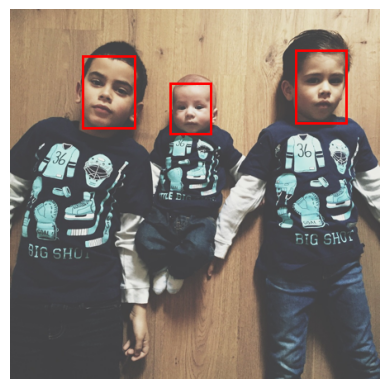

In [ ]:
draw_bounding_box(image_path,boxes)